# Training Values

First, all functions needed to execute values are inserted in the code. Later, the GridSearchCV method from sklearn is used to find the best values for the training data for svm.

In [40]:
import cv2
import numpy as np
import pickle
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import itertools
from matplotlib import style
style.use("ggplot")
from sklearn import svm
from visualization import plot_accuracy_vs_time, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

def open_pkl(pkl_file):
    """
    This function opens pkl files providing file name on WD.
    """    
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)    
    return data

train_images_filenames = open_pkl('train_images_filenames.dat')
train_labels = open_pkl('train_labels.dat')
test_images_filenames = open_pkl('test_images_filenames.dat')
test_labels = open_pkl('test_labels.dat')

def compute_detector(sift_step_size, sift_scale, n_features = 300):
    """
    Computes Sift detector objest.
    Computes mesh of KPs using a custom step size and scale value(s).
    """    
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=n_features)
    if(isinstance(sift_scale, list) == False):
        sift_scale = [sift_scale]
    kpt = [cv2.KeyPoint(x, y, scale) for y in 
           range(0, 256, sift_step_size) for x in 
           range(0, 256, sift_step_size) for scale in sift_scale ]
    return (SIFTdetector, kpt)    

def create_BOW(dense, SIFTdetector, kpt, k_codebook):
    
    train_images_filenames = open_pkl('train_images_filenames.dat')
    train_labels = open_pkl('train_labels.dat')
      
    Train_descriptors = []
    Train_label_per_descriptor = []
     
    for filename, labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if dense:
            (_, des) = SIFTdetector.compute(gray, kpt)
            #norm here
        else:
            (_, des) = SIFTdetector.detectAndCompute(gray, None)
            #norm here
            
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
 
    D =  np.vstack(Train_descriptors)
    
    codebook = MiniBatchKMeans(n_clusters=k_codebook, batch_size=k_codebook*20,
                               compute_labels=False, reassignment_ratio=10**-4, 
                               random_state=42)
    codebook.fit(D)
    
    visual_words = np.zeros((len(Train_descriptors),k_codebook),dtype=np.float32)    
    for i in range(len(Train_descriptors)):
        words = codebook.predict(Train_descriptors[i])
        visual_words[i,:] = np.bincount(words, minlength = k_codebook)
        #norm here
    return codebook, visual_words, train_labels 

def classify_BOW(dense, k_codebook, visual_words, codebook, train_labels,clf):
    
    test_images_filenames = open_pkl('test_images_filenames.dat')
    test_labels = open_pkl('test_labels.dat')
    
    # Fit model with training data  
    clf.fit(visual_words, train_labels) 
    
    visual_words_test=np.zeros((len(test_images_filenames),k_codebook),
                               dtype=np.float32)
    
    
    for i in range(len(test_images_filenames)):
    
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if dense:
            (kp, des) = SIFTdetector.compute(gray, kpt)
        else:
            (kp, des) = SIFTdetector.detectAndCompute(gray,None)  
            
        words = codebook.predict(des)
        visual_words_test[i,:] = np.bincount(words,minlength=k_codebook)
        

    # Score Results with Test Data
    accuracy = 100*clf.score(visual_words_test, test_labels)
    
    predicted_labels = clf.predict(visual_words_test)
    
    unique_labels = list(set(train_labels))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_labels, 
                                  predicted_labels, labels = unique_labels)

    return accuracy, cnf_matrix, unique_labels

## Classifier Initialization

SVM allows different kernels to be initialized, so, the method initialized svm with different models

In [43]:
def init_classifier_svm(svm_param):
    
    models = (svm.SVC(kernel=svm_param["kernel"][0], C=svm_param["C_linear"]),
          svm.LinearSVC(C=svm_param["C_linear2"]),
          svm.SVC(kernel=svm_param["kernel"][1], gamma=svm_param["gamma"], C=svm_param["C_rbf"]),
          svm.SVC(kernel=svm_param["kernel"][2], degree=svm_param["degree"], C=svm_param["C_poly"]))
    
    return models

In [53]:
# Determines total number of kps in an given image (set composed of 256x256px img)
sift_step_size = 20
# List providing scale values to compute at each kp
sift_scale = [16]
# Dense/Normal Sift 
dense = True
# Number of clusters in KMeans, size of codebook (words)
k_codebook = 128

type_classifier = "SVM"
knn_dict ={
  "k_classifier": 5,
  "distance_method": "euclidean",
}
svm_dict ={
    "kernel": ["linear", "rbf", "poly"],
    "C_linear": 0.1,
    "C_linear2": 0.1,
    "C_rbf": 1,
    "C_poly": 0.1,
    "gamma": 0.001,
    "degree": 1,
}
# INIT CLASSIFIER
if type_classifier == "KNN": 
    classifier = init_classifier_knn(knn_dict)
elif type_classifier =="SVM":
    # Retorna llistat de models: Linear, LinearSVC, RBF, Poly
    classifier_svm = init_classifier_svm(svm_dict)
else:
    sys.exit("Invalid Classifier")  

After initializing variables, first, we need to compute the visual_words for the training data, as it will be the input to our classifier

In [20]:
start = time.time()   

(SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
print(len(kpt))
codebook, visual_words, labels = create_BOW(dense, SIFTdetector, 
                                         kpt, k_codebook)   

169


Now, we are going to train the SVM kernels with different parameters to find the best ones for our training data

### Linear Kernel: OVO

In [49]:
# Grid Search
# Parameter Grid
param_grid = {'C': [0.1, 1, 10, 100]}
 
# Make grid search classifier
clf_grid = GridSearchCV(svm.SVC(kernel='linear', decision_function_shape='ovo'), param_grid, verbose=1, n_jobs=4)
 
# Train the classifier
clf_grid.fit(visual_words, train_labels)
 
# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.5s finished


Best Parameters:
 {'C': 0.1}
Best Estimators:
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Linear Kernel: OVR

In [50]:
# Grid Search
# Parameter Grid
param_grid = {'C': [0.1, 1, 10, 100]}
 
# Make grid search classifier
clf_grid = GridSearchCV(svm.LinearSVC(), param_grid, verbose=1, n_jobs=4)
 
# Train the classifier
clf_grid.fit(visual_words, train_labels)
 
# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.4s finished


Best Parameters:
 {'C': 0.1}
Best Estimators:
 LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


### RBF Kernel

In [51]:
# Grid Search
# Parameter Grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]}
 
# Make grid search classifier
clf_grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, verbose=1, n_jobs=4)
 
# Train the classifier
clf_grid.fit(visual_words, train_labels)
 
# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:   13.4s finished


Best Parameters:
 {'C': 1, 'gamma': 0.001}
Best Estimators:
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Polynomial

In [52]:
# Grid Search
# Parameter Grid
param_grid = {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5, 6,7,8,9,10]}
 
# Make grid search classifier
clf_grid = GridSearchCV(svm.SVC(kernel='poly'), param_grid, verbose=1, n_jobs=4)
 
# Train the classifier
clf_grid.fit(visual_words, train_labels)
 
# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   16.6s finished


Best Parameters:
 {'C': 0.1, 'degree': 1}
Best Estimators:
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Apply SVM with new parameters for the kernels

Accuracy:  79.42998760842627


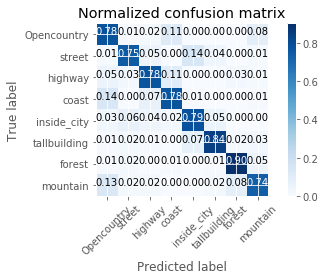

Accuracy:  77.69516728624535


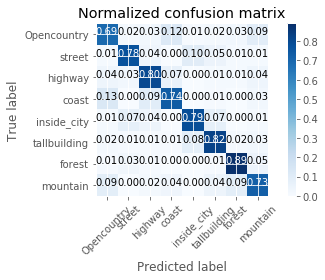

Accuracy:  82.40396530359355


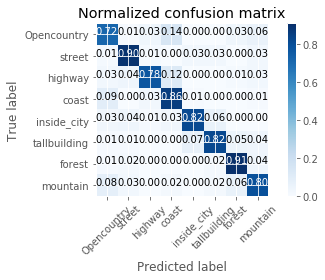

Accuracy:  82.15613382899627


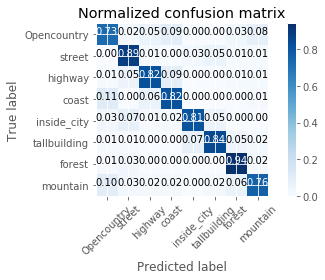

In [55]:
accuracy_list=[]
#classifier = classifier_svm[2]

for classifier in classifier_svm:
    accuracy, cnf_matrix, unique_labels = classify_BOW(dense, k_codebook, 
                                                       visual_words, codebook,labels, classifier)
    accuracy_list.append(accuracy)

    print ("Accuracy: ",accuracy) 
    
    np.set_printoptions(precision=2)  
    plot_confusion_matrix(cnf_matrix, classes=unique_labels, 
                      normalize=True,
                      title='Normalized confusion matrix') 
